In [14]:
import sys
sys.path.append("../SpikeCounter")
import numpy as np
import skimage.io as skio
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imsave
import matplotlib.colors as colors
import matplotlib.patches as patches
import os
from scipy import interpolate, optimize, ndimage, stats, signal, fft
from skimage import filters, transform, morphology, exposure, measure
from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils
import colorcet as cc
from cycler import cycler
from scipy.io import loadmat
import mat73
from sklearn.utils.extmath import randomized_svd
import pandas as pd

plt.style.use("../bio_pubs_presentation.mplstyle")

1.5V = x mW/mm^2

In [2]:
V0 = 38e-3/(41499*7.048e-8)

In [3]:
V0/1.5*np.array([1,2,3,4])

array([ 8.66141426, 17.32282851, 25.98424277, 34.64565703])

### Load metadata and video

In [4]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20220212_gtacr_targeted_silencing/"
if not os.path.isdir(os.path.join(rootdir, "analysis")):
    os.mkdir(os.path.join(rootdir, "analysis"))

In [5]:
expt_info = pd.read_csv(os.path.join(rootdir, "analysis", "experiment_data.csv")).sort_values("start_time").reset_index()

In [6]:
expts = expt_info["file_name"].iloc[5:].tolist()

In [661]:
filename = expts[1]
print(filename)
img, expt_data = images.load_image(rootdir, filename, subfolder="downsampled")
traces_dict, dt = utils.traces_to_dict(expt_data)
print(dt)
stim_edges = np.argwhere(np.diff(traces_dict["enable488"]) != 0).ravel()-20

103704E4_silencing_target3_1V_OD0
0.02053


/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 20 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))


In [622]:
img.shape

(2901, 216, 216)

### Get biological landmark

In [623]:
!ls {os.path.join(rootdir, "Snaps")}

091140fastcal.tiff	     100354E4_nkx.tiff
091521lightcrafter_cal.tiff  102614E4_silencing_snap2.tiff
094049lightcrafter_cal.tiff  110927E5_snap.tiff
094125lightcrafter_cal.tiff  111018E5_fullfov_1V.tiff
094523lightcrafter_cal.tiff  111636E6_fullfov_1V.tiff
095200conetarget.tiff	     111725E6_fullfov_1V.tiff
100348E4_nkx.tiff


In [624]:
nkx_path = "111725E6_fullfov_1V.tiff"
nkx = skio.imread(os.path.join(rootdir, "Snaps", nkx_path))
factor = 4

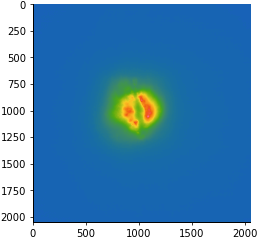

In [625]:
plt.imshow(nkx)

In [626]:
nkx_downsample = transform.downscale_local_mean(nkx, (factor,factor))
offset = [(nkx_downsample.shape[0]-img.shape[1])//2, (nkx_downsample.shape[1]-img.shape[2])//2]
nkx_downsample = nkx_downsample[offset[0]:-offset[0],offset[1]:-offset[1]]

In [627]:
mean_intensity = img.mean(axis=0)

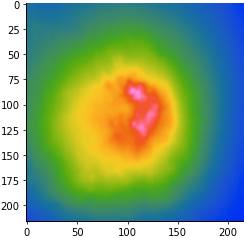

In [628]:
plt.imshow(mean_intensity)

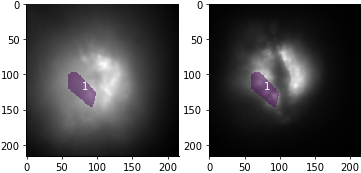

In [480]:
factor = 4
fig1, axes = plt.subplots(1,2, figsize=(6,3))
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
# plt.imshow(target_img_space)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
target_img_space = target_img_space.astype(bool)
q = visualize.display_roi_overlay(mean_intensity, target_img_space.astype(int), ax=axes[0])
q2 = visualize.display_roi_overlay(nkx_downsample, target_img_space.astype(int), ax=axes[1])

In [425]:
full_clicky_rois = np.copy(target_img_space.astype(int))

(216, 216)
[0 1 2]


<IPython.core.display.Javascript object>


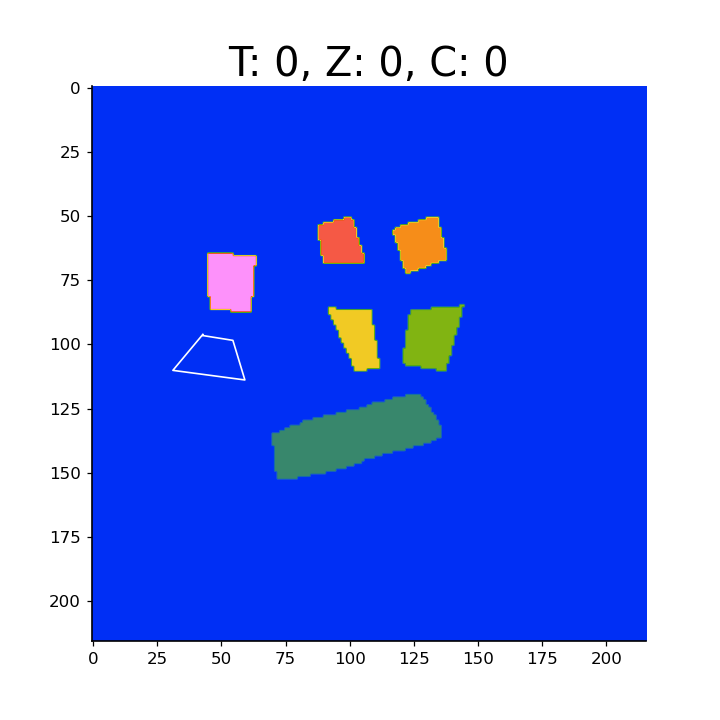

This happened


In [436]:
%matplotlib notebook
plt.close("all")
h = HyperStackViewer(full_clicky_rois, width=6, height=6)
mask = h.select_region_clicky()

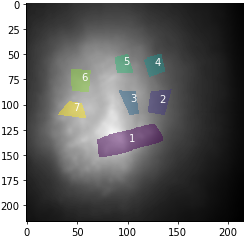

In [437]:
full_clicky_rois += (h._points_to_mask(h.points, propagate_z=True).squeeze())*(np.max(full_clicky_rois)+1)
%matplotlib inline
fig1, ax1 = plt.subplots(figsize=(4,4))
q = visualize.display_roi_overlay(mean_intensity, full_clicky_rois.astype(int), ax=ax1)

In [438]:
traces = []
for i in range(1, np.max(full_clicky_rois)+1):
    traces.append(images.extract_mask_trace(img, mask=full_clicky_rois==i))
traces = np.array(traces)

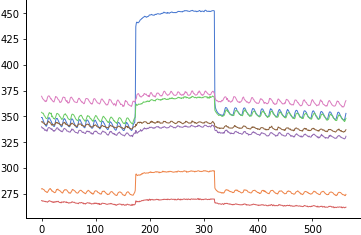

In [439]:
plt.plot(traces.T)

In [440]:
stim_edges = np.argwhere(np.diff(traces_dict["enable488"]) != 0).ravel()-20
traces_crosstalk_removed = np.copy(traces)
traces_crosstalk_removed[:,stim_edges[0]+2:stim_edges[1]+1] -= \
                            (np.median(traces_crosstalk_removed[:,stim_edges[0]:stim_edges[1]], axis=1) -\
                             traces_crosstalk_removed[:,stim_edges[1]+2])[:,np.newaxis]
# traces_crosstalk_removed = traces

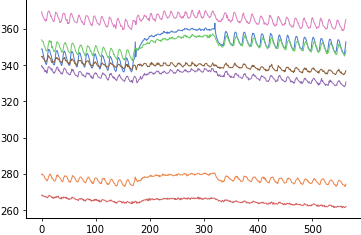

In [441]:
plt.plot(traces_crosstalk_removed.T)

In [442]:
normalized_traces = np.divide((traces_crosstalk_removed - np.min(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1)[:,np.newaxis]), (np.max(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1) - \
                                                               np.min(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1))[:,np.newaxis])

In [443]:
before_trace = normalized_traces[:,:stim_edges[0]-int(4/dt)]
after_trace = normalized_traces[:,stim_edges[1]+int(4/dt):]
during_trace = normalized_traces[:,stim_edges[0]+int(2/dt):stim_edges[1]-int(2/dt)]


In [460]:
def find_pks_along_axis(dat, plot=False, offset=1):
    def auto_prom_pks(x):
        x1 = x - np.mean(x)
        if 1/dt > 20:
            sos = signal.butter(5, 10, fs=1/dt, output='sos')
            x1 = signal.sosfiltfilt(sos, x1)
#         print(x1)
        prom = max((np.percentile(x1, 90) - np.percentile(x1, 10))*0.4, 0.3)
#         pks = signal.find_peaks(x1,prominence=prom, width=(20,None))
        pks = signal.find_peaks(x1,prominence=prom, width=(3,None))
        return pks
    pks = np.apply_along_axis(lambda x: auto_prom_pks(x), 1, dat)[:,0]
    if plot:
        fig1, ax1 = plt.subplots(figsize=(8, 1*dat.shape[0]))
        for i in range(len(pks)):
            ax1.plot(dat[i,:]+i*offset)
            ax1.plot(pks[i], dat[i,pks[i]]+i*offset, "kx")
    return pks

In [461]:
traces_by_time_window = [before_trace, during_trace, after_trace]
freqs = []

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/shape_base.py:402: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

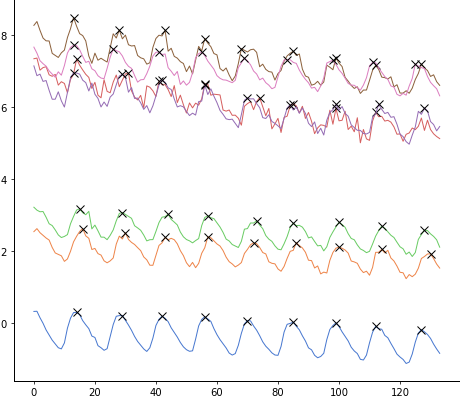

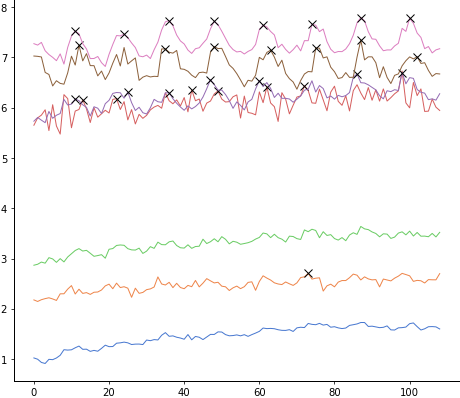

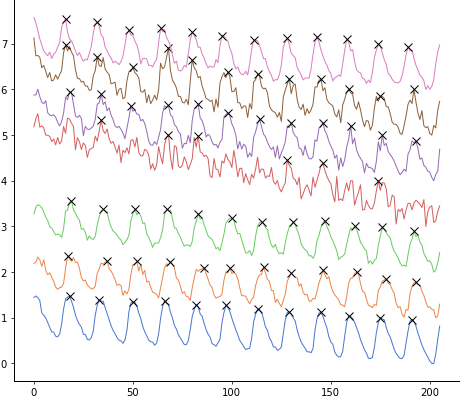

In [462]:
for tr in traces_by_time_window:
    pks = find_pks_along_axis(tr, plot=True)
#     freq = [len(pk)/(tr.shape[1]*dt) for pk in list(pks)]
    freq = [1/(np.mean(np.diff(pk))*dt) for pk in list(pks)]

    freqs.append(freq)

In [465]:
freqs = np.array(freqs)

In [466]:
freqs[np.isnan(freqs)] = 0

In [467]:
freqs

array([[0.68982228, 0.6837712 , 0.68982228, 0.6959814 , 0.67782537,
        0.6837712 , 0.6959814 ],
       [0.        , 0.        , 0.        , 0.82574065, 0.67198204,
        0.64958264, 0.76636155],
       [0.61954414, 0.60898373, 0.61954414, 0.3479907 , 0.61246363,
        0.60898373, 0.61954414]])

Text(0.5, 0, 'Time (s)')

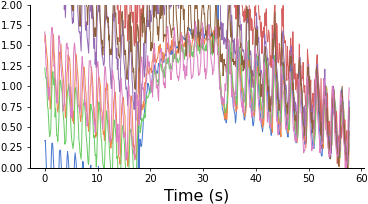

In [449]:
fig1, ax1 = plt.subplots(figsize=(6,3))
ax1.plot(dt*np.arange(normalized_traces.shape[1]), normalized_traces.T)
ax1.set_ylim((0, 2))
ax1.set_xlabel("Time (s)")

In [463]:
    
def stackplot(y, xvals=None, figsize_single=(12,1), ax=None, offset=None):
    if offset is None:
        offset = np.max(np.max(y, axis=1) - np.min(y, axis=1))
    if ax is None:
        fig1, ax = plt.subplots(figsize=(figsize_single[0],figsize_single[1]*y.shape[0]))
    else:
        fig1 = ax.figure
    for i in range(y.shape[0]):
        if xvals is None:
            ax.plot(y[i,:] + i*offset)
        else:
            ax.plot(xvals, y[i,:] + i*offset)
    return fig1, ax

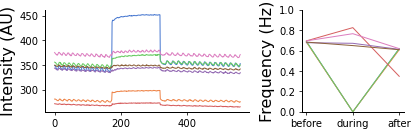

In [468]:
xvals = dt*np.arange(normalized_traces.shape[1])
fig1, axes = plt.subplots(1,2, figsize=(6,2), gridspec_kw={"width_ratios":[4,2]})
q = stackplot(traces, offset=1, figsize_single=(4,0.5), ax=axes[0])
axes[1].plot(["before", "during", "after"], freqs)
ax1.set_xlabel("Time (s)")
# ax1.set_ylim(-1, 13)
axes[0].set_ylabel("Intensity (AU)")
axes[1].set_ylabel("Frequency (Hz)")
axes[1].set_ylim((0,1))
plt.tight_layout()
plt.savefig(os.path.join(rootdir, "analysis", "%s_clicky.svg" % filename))

Text(0, 0.5, 'Intensity (AU)')

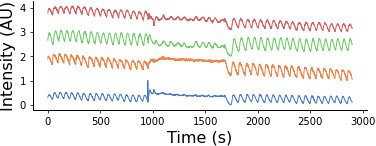

In [331]:
# xvals = dt*np.arange(normalized_traces.shape[1])
# fig1, ax1 = stackplot(normalized_traces, offset=1, figsize_single=(4,0.5))
# ax1.set_xlabel("Time (s)")
# # ax1.set_ylim(-1, 13)
# ax1.set_ylabel("Intensity (AU)")

In [469]:
def display_roi_overlay(img, mask, textcolor="white", alpha=0.5, ax=None, cmap="gray", mask_cmap="viridis"):
    """ Display an image with a labelled integer valued overlay
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 12))
    else:
        fig = ax.figure
        
    props = measure.regionprops(mask)
    mask = np.ma.masked_where(mask==0, mask)
        
    im = ax.imshow(img, cmap=cmap)
    ax.imshow(mask, interpolation='none', alpha=alpha, cmap=mask_cmap, vmin=1, vmax = 10)
    if textcolor is not None:
        for idx, obj in enumerate(props):
            centroid = obj.centroid
            ax.text(centroid[1], centroid[0], str(idx+1), color=textcolor)
    return fig, ax, im

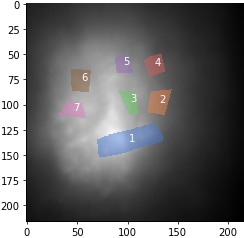

In [470]:
fig1, ax1 = plt.subplots(figsize=(4,4))
q = display_roi_overlay(mean_intensity, full_clicky_rois.astype(int), ax=ax1, mask_cmap=colors.ListedColormap(['#4878d0', '#ee854a', '#6acc64', '#d65f5f', '#956cb4', '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']))

In [471]:
skio.imsave(os.path.join(rootdir, "analysis", "%s_clicky_mask.tif" %filename), full_clicky_rois)
# skio.imsave(os.path.join(rootdir, "analysis", "intensity_propagation_mask.tif"), full_clicky_rois)

/tmp/ipykernel_250013/1714221348.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220212_gtacr_targeted_silencing/analysis/112954E6_fullfov_target4_1V_OD0_clicky_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "%s_clicky_mask.tif" %filename), full_clicky_rois)


### Compare pairs of stimulated points

In [6]:
def get_dmd_target_scaled(expt_data, img, factor=4):
    target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
    target_img_space = target_img_space[::factor,::factor]
    offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
    target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
    target_img_space = target_img_space.astype(bool)
    return target_img_space

In [7]:
def get_normalized_traces(img, rois, traces_dict, dt, start_frames_removed=10):
    traces = []
    for i in range(1, np.max(rois)+1):
        traces.append(images.extract_mask_trace(img, mask=rois==i))
    traces = np.array(traces)
    
    stim_edges = np.argwhere(np.diff(traces_dict["enable488"]) != 0).ravel()-10
    traces_crosstalk_removed = np.copy(traces)
    traces_crosstalk_removed[:,stim_edges[0]+2:stim_edges[1]+1] -= \
                                (np.median(traces_crosstalk_removed[:,stim_edges[0]:stim_edges[1]], axis=1) -\
                                 traces_crosstalk_removed[:,stim_edges[1]+2])[:,np.newaxis]
    normalized_traces = np.divide((traces_crosstalk_removed - np.min(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1)[:,np.newaxis]), (np.max(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1) - \
                                                               np.min(traces_crosstalk_removed[:,stim_edges[1]+200:], axis=1))[:,np.newaxis])
    
    before_trace = normalized_traces[:,:stim_edges[0]-int(4/dt)]
    after_trace = normalized_traces[:,stim_edges[1]+int(4/dt):]
    during_trace = normalized_traces[:,stim_edges[0]+int(2/dt):stim_edges[1]-int(2/dt)]
    return normalized_traces, (before_trace, during_trace, after_trace)

In [8]:
def apply_ft_along_axis(arr, dt):
    N = arr.shape[1]
    yabs = np.apply_along_axis(lambda x: 2.0/N*np.abs(fft.fft(x)[:N//2]), \
                                      1, arr-np.mean(arr, axis=1)[:,np.newaxis])
    xf = fft.fftfreq(N, dt)[:N//2]
    return xf, yabs
def get_paired_frequency_spectra(before_traces, during_traces, dt):
    xf_before, yabs_before = apply_ft_along_axis(before_traces, dt)
    xf_during, yabs_during = apply_ft_along_axis(during_traces, dt)
    
    return xf_before, yabs_before, xf_during, yabs_during


In [9]:
expt_info["file_name"]

0                095625E2_endogenous_activity
1           095851E2_endogenous_activity_10Hz
2               100114E4_endogenous_activity_
3           102247E4_silencing_4V_OD0_target1
4                  102759E4_silencing_target2
5           103103E4_silencing_target2_1V_OD0
6           103704E4_silencing_target3_1V_OD0
7           103906E4_silencing_target4_1V_OD0
8           104231E4_silencing_target5_1V_OD0
9           104654E4_silencing_target6_1V_OD0
10          105034E4_silencing_target7_1V_OD0
11          105213E4_silencing_target8_1V_OD0
12     105530E4_silencing_target9_1V_OD0_10Hz
13    105730E4_silencing_target10_1V_OD0_10Hz
14    105857E4_silencing_target10_2V_OD0_10Hz
15    110111E4_silencing_target11_1V_OD0_10Hz
16    110317E4_silencing_target11_2V_OD0_10Hz
17    110528E4_silencing_target11_3V_OD0_10Hz
18    110650E4_silencing_target11_4V_OD0_10Hz
19                        112033E6_fullfov_1V
20            112305E6_fullfov_traget1_1V_OD0
21            112618E6_fullfov_tar

112305E6_fullfov_traget1_1V_OD0
112618E6_fullfov_target2_1V_OD0
112806E6_fullfov_target3_1V_OD0
112954E6_fullfov_target4_1V_OD0


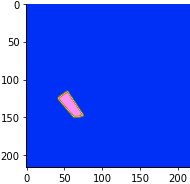

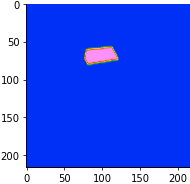

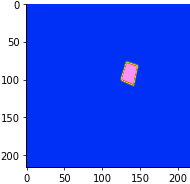

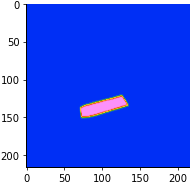

In [11]:
embryo = 6
for filename in list(expt_info["file_name"]):
    if "E%d" % embryo in filename and ("target" in filename or "traget" in filename):
        try:
            expt_data = mat73.loadmat(os.path.join(rootdir, filename, "output_data_py.mat"))["dd_compat_py"]
        except Exception:
            continue
        print(filename)
        factor = 4
        target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
        target_img_space = target_img_space[::factor,::factor]
        offset = [(target_img_space.shape[0]-216)//2, (target_img_space.shape[1]-216)//2]
        target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
        fig1, ax1 = plt.subplots(figsize=(3,3))
        ax1.imshow(target_img_space)

In [16]:
pairs = [("103704E4_silencing_target3_1V_OD0", "103906E4_silencing_target4_1V_OD0"), \
        ("112305E6_fullfov_traget1_1V_OD0", "112806E6_fullfov_target3_1V_OD0"), \
        ("112618E6_fullfov_target2_1V_OD0", "112806E6_fullfov_target3_1V_OD0")]
# start_frames_removed = [10,10,10,10,10]

/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 20 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))
/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 20 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))
/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py:37: UserWarning: 20 frames dropped
  warnings.warn("%d frames dropped" % (fc_max - img.shape[0]))


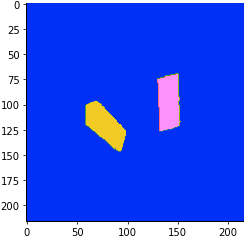

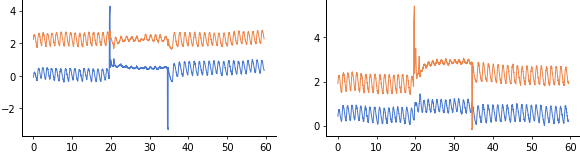

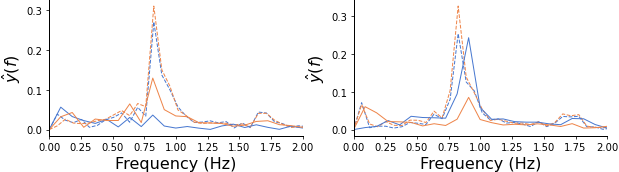

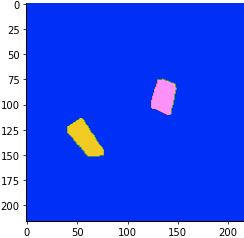

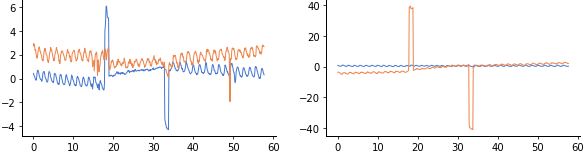

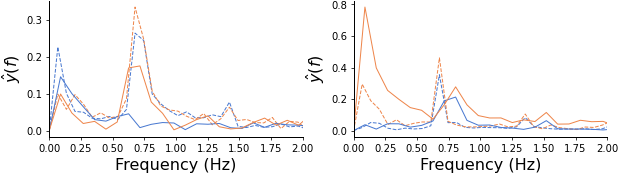

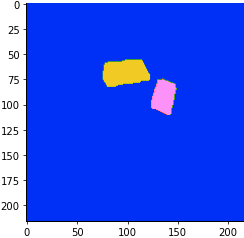

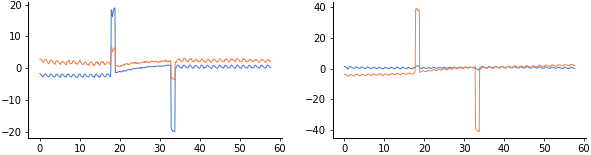

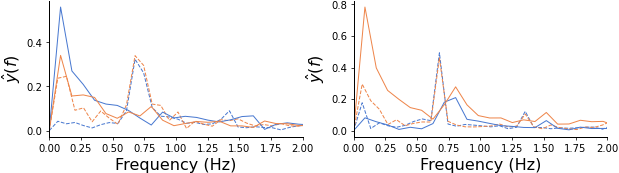

In [17]:
for pair in pairs:
    img1, expt_data1 = images.load_image(rootdir, pair[0], subfolder="downsampled")
    img2, expt_data2 = images.load_image(rootdir, pair[1], subfolder="downsampled")
    img1 = images.correct_photobleach(img1, method="linear")
    img2 = images.correct_photobleach(img2, method="linear")
    trace_dict1, dt1 = utils.traces_to_dict(expt_data1)
    trace_dict2, dt2 = utils.traces_to_dict(expt_data2)
    
    paired_targets = get_dmd_target_scaled(expt_data1, img1).astype(int) + \
                        get_dmd_target_scaled(expt_data2, img2).astype(int)*2
    fig1, ax1 = plt.subplots(figsize=(4,4))
    ax1.imshow(paired_targets)
    
    nt1, nt1_split = get_normalized_traces(img1, paired_targets, trace_dict1, dt1, start_frames_removed=20)
    nt2, nt2_split = get_normalized_traces(img2, paired_targets, trace_dict2, dt2, start_frames_removed=20)
    
    xvals1 = np.arange(nt1.shape[1])*dt1
    xvals2 = np.arange(nt2.shape[1])*dt2
    
    fig1, axes = plt.subplots(1, 2, figsize=(10,2.5))
    q = visualize.stackplot(nt1, xvals=xvals1, offset=1.8, figsize_single=(4,0.5), ax=axes[0])
    q = visualize.stackplot(nt2, xvals=xvals2, offset=1.8, figsize_single=(4,0.5), ax=axes[1])
    
    xf_before, yabs_before, xf_during, yabs_during = get_paired_frequency_spectra(nt1_split[0], nt1_split[1], dt1)
    
        
    fig1, axes = plt.subplots(1,2, figsize=(10, 2.5))
    axes[0].plot(xf_before, yabs_before[0,:], color="C0", ls="--")
    axes[0].plot(xf_before, yabs_before[1,:], color="C1", ls="--")

    axes[0].plot(xf_during, yabs_during[0,:], color="C0")
    axes[0].plot(xf_during, yabs_during[1,:], color="C1")
    
    axes[0].set_xlim((0, 2))
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel(r"$\hat{y}(f)$")
    
    xf_before, yabs_before, xf_during, yabs_during = get_paired_frequency_spectra(nt2_split[0], nt2_split[1], dt2)
    axes[1].plot(xf_before, yabs_before[0,:], color="C0", ls="--")
    axes[1].plot(xf_before, yabs_before[1,:], color="C1", ls="--")

    axes[1].plot(xf_during, yabs_during[0,:], color="C0")
    axes[1].plot(xf_during, yabs_during[1,:], color="C1")

    axes[1].set_xlim((0, 2))
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel(r"$\hat{y}(f)$")
#     plt.savefig(os.path.join(rootdir, "analysis", "mutual_acceleration.svg"))

### Find endogenous initiation site

Before silencing

In [629]:
before_stim_img = img[:stim_edges[0]-int(2/dt),:,:]

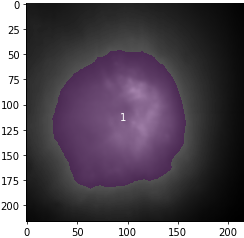

In [630]:
mean_img = before_stim_img.mean(axis=0)
fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.imshow(mean_img)
intensity_mask = mean_img > np.percentile(mean_img, 70)
q = visualize.display_roi_overlay(mean_img, intensity_mask.astype(int), ax=ax1)

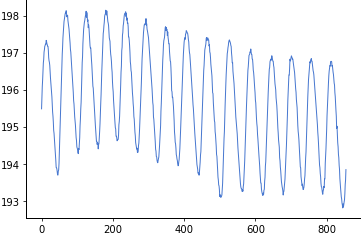

In [631]:
mean_trace = images.extract_mask_trace(before_stim_img, mask=intensity_mask)
plt.plot(mean_trace)

In [587]:
nsamps = (int(2/dt)//2)*2 +1
pb_corrected_img = images.correct_photobleach(before_stim_img, mask=intensity_mask, method="localmin", nsamps=nsamps)

mean_img = pb_corrected_img.mean(axis=0)
t_zeroed = pb_corrected_img - mean_img
data_matrix = t_zeroed.reshape((t_zeroed.shape[0], -1))
sos = signal.butter(5,[17,19],btype="bandstop", output="sos", fs = 1/dt)
data_matrix_filtered = np.apply_along_axis(lambda x: signal.sosfiltfilt(sos, x), 0, data_matrix)
u, s, v = randomized_svd(data_matrix_filtered, n_components=60)
n_pcs = 30
use_pcs = np.zeros_like(s,dtype=bool)
use_pcs[:n_pcs] = True

denoised = u[:,use_pcs]@ np.diag(s[use_pcs]) @ v[use_pcs,:]
denoised = denoised.reshape(pb_corrected_img.shape)
denoised += mean_img
dFF_before = images.get_image_dFF(denoised)
dFF_trace = images.extract_mask_trace(dFF_before, mask=intensity_mask)

(855, 216, 216)


/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


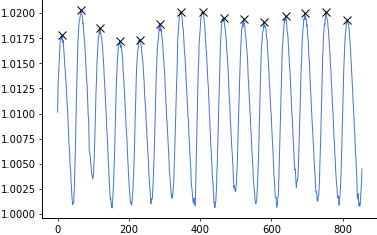

In [588]:
pks, _ = signal.find_peaks(dFF_trace, prominence=0.005, width=(5,None))
plt.plot(dFF_trace)
plt.plot(pks, dFF_trace[pks], "kx")

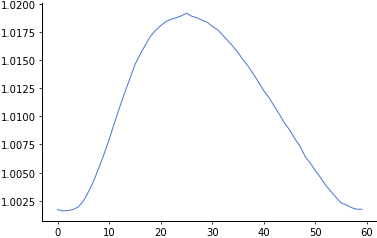

In [590]:
sta_before = images.spike_triggered_average_video(dFF_before, pks, 25, 35)
sta_trace = images.extract_mask_trace(sta_before, mask=intensity_mask)
plt.plot(sta_trace)

In [591]:
skio.imsave(os.path.join(rootdir, "%s_sta_before.tif" % filename), sta_before)
utils.display_zstack(sta_before[:,:,:, np.newaxis], c=0, pct_cutoffs=[0,100])

/tmp/ipykernel_250013/3844878937.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220212_gtacr_targeted_silencing/103704E4_silencing_target3_1V_OD0_sta_before.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "%s_sta_before.tif" % filename), sta_before)


interactive(children=(IntSlider(value=29, description='z', max=59), Dropdown(description='c', options=('all', …

After silencing is over

In [592]:
after_stim_img = img[stim_edges[1]+int(2/dt):,:,:]

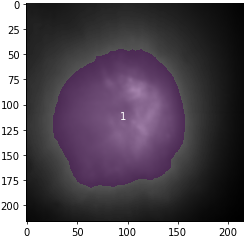

In [593]:
mean_img = after_stim_img.mean(axis=0)
fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.imshow(mean_img)
intensity_mask = mean_img > np.percentile(mean_img, 70)
q = visualize.display_roi_overlay(mean_img, intensity_mask.astype(int), ax=ax1)

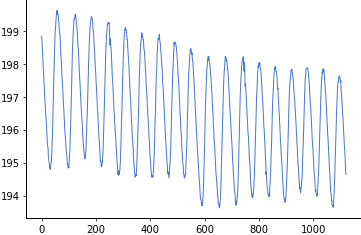

In [594]:
mean_trace = images.extract_mask_trace(after_stim_img, mask=intensity_mask)
plt.plot(mean_trace)

In [595]:
nsamps = (int(2/dt)//2)*2 +1
pb_corrected_img = images.correct_photobleach(after_stim_img, mask=intensity_mask, method="localmin", nsamps=nsamps)

mean_img = pb_corrected_img.mean(axis=0)
t_zeroed = pb_corrected_img - mean_img
data_matrix = t_zeroed.reshape((t_zeroed.shape[0], -1))
sos = signal.butter(5,[17,19],btype="bandstop", output="sos", fs = 1/dt)
data_matrix_filtered = np.apply_along_axis(lambda x: signal.sosfiltfilt(sos, x), 0, data_matrix)
u, s, v = randomized_svd(data_matrix_filtered, n_components=60)
n_pcs = 30
use_pcs = np.zeros_like(s,dtype=bool)
use_pcs[:n_pcs] = True

denoised = u[:,use_pcs]@ np.diag(s[use_pcs]) @ v[use_pcs,:]
denoised = denoised.reshape(pb_corrected_img.shape)
denoised += mean_img
dFF_after = images.get_image_dFF(denoised)
dFF_trace_after = images.extract_mask_trace(dFF_after, mask=intensity_mask)

(1121, 216, 216)


/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


In [596]:
dFF_trace_after = images.extract_mask_trace(dFF_after, mask=intensity_mask)

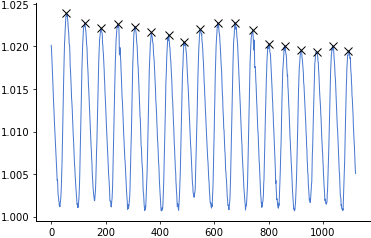

In [597]:
pks, _ = signal.find_peaks(dFF_trace_after, prominence=0.005, width=(5,None))
plt.plot(dFF_trace_after)
plt.plot(pks, dFF_trace_after[pks], "kx")

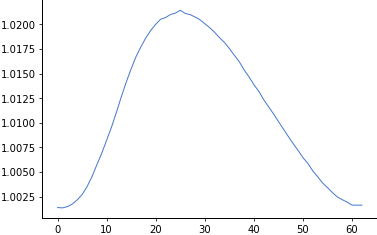

In [598]:
sta_after = images.spike_triggered_average_video(dFF_after, pks, 25, 38)
sta_trace = images.extract_mask_trace(sta_after, mask=intensity_mask)
plt.plot(sta_trace)

In [599]:
utils.display_zstack(sta_after[:,:,:, np.newaxis], c=0, pct_cutoffs=[0,100])

interactive(children=(IntSlider(value=31, description='z', max=62), Dropdown(description='c', options=('all', …

In [600]:
skio.imsave(os.path.join(rootdir, "%s_sta_after.tif" % filename), sta_after)

/tmp/ipykernel_250013/1464582390.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220212_gtacr_targeted_silencing/103704E4_silencing_target3_1V_OD0_sta_after.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "%s_sta_after.tif" % filename), sta_after)


During silencing

In [662]:
full_clicky_rois = skio.imread(os.path.join(rootdir, "analysis", "%s_clicky_mask.tif" % filename))

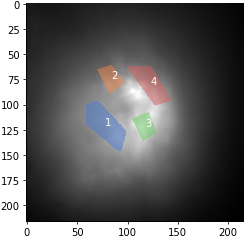

In [663]:
fig1, ax1 = plt.subplots(figsize=(4,4))
q = display_roi_overlay(mean_intensity, full_clicky_rois.astype(int), ax=ax1, mask_cmap=colors.ListedColormap(['#4878d0', '#ee854a', '#6acc64', '#d65f5f', '#956cb4', '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']))

In [664]:
during_img = img[stim_edges[0]+int(1.5/dt):stim_edges[1]-int(1.5/dt),:,:]

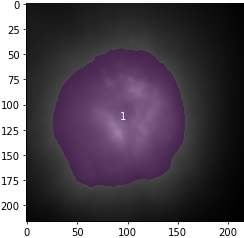

In [665]:
mean_img = during_img.mean(axis=0)
fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.imshow(mean_img)
intensity_mask = mean_img > np.percentile(mean_img, 70)
q = visualize.display_roi_overlay(mean_img, intensity_mask.astype(int), ax=ax1)

In [666]:
print(np.mean(mean_img[intensity_mask]))

205.40932372062062


In [667]:
print(np.mean(mean_img[full_clicky_rois==1]))

248.14630567308654


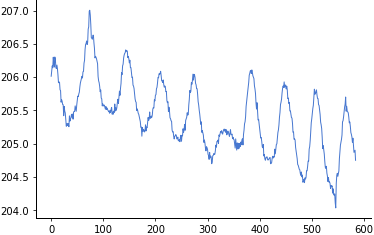

In [668]:
mean_trace = images.extract_mask_trace(during_img, mask=intensity_mask)
plt.plot(mean_trace)

In [669]:
nsamps = (int(2/dt)//2)*2 +1
pb_corrected_img = images.correct_photobleach(during_img, mask=intensity_mask, method="linear", nsamps=nsamps)

mean_img = pb_corrected_img.mean(axis=0)
t_zeroed = pb_corrected_img - mean_img
data_matrix = t_zeroed.reshape((t_zeroed.shape[0], -1))
sos = signal.butter(5,[17,19],btype="bandstop", output="sos", fs = 1/dt)
data_matrix_filtered = np.apply_along_axis(lambda x: signal.sosfiltfilt(sos, x), 0, data_matrix)
u, s, v = randomized_svd(data_matrix_filtered, n_components=60)
n_pcs = 30
use_pcs = np.zeros_like(s,dtype=bool)
use_pcs[:n_pcs] = True

denoised = u[:,use_pcs]@ np.diag(s[use_pcs]) @ v[use_pcs,:]
denoised = denoised.reshape(pb_corrected_img.shape)
denoised += mean_img
dFF_during = images.get_image_dFF(denoised)

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


In [670]:
dF_during = denoised - denoised.mean(axis=0)

In [671]:
dF_trace_during = images.extract_mask_trace(dF_during, mask=(full_clicky_rois==4))

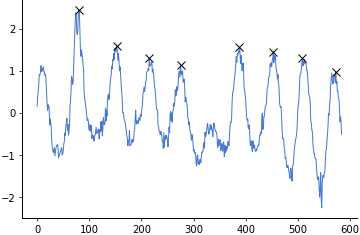

In [672]:
pks, _ = signal.find_peaks(dF_trace_during, prominence=1, width=(5,None))
plt.plot(dF_trace_during)
plt.plot(pks, dF_trace_during[pks], "kx")

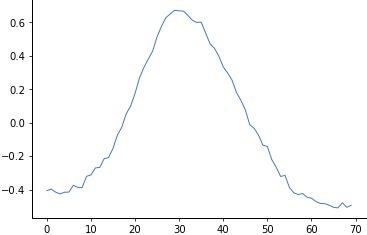

In [674]:
sta_during = images.spike_triggered_average_video(dF_during, pks, 35, 35)
sta_trace = images.extract_mask_trace(sta_during, mask=intensity_mask)
plt.plot(sta_trace)

In [675]:
skio.imsave(os.path.join(rootdir, "%s_sta_during.tif" % filename), sta_during)
utils.display_zstack(sta_during[:,:,:, np.newaxis], c=0, pct_cutoffs=[0,100])

interactive(children=(IntSlider(value=34, description='z', max=69), Dropdown(description='c', options=('all', …